<a href="https://colab.research.google.com/github/Saif-M-Dhrubo/hierarchical-attention-HAR/blob/master/MeX_HSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!nvidia-smi

Wed Apr 15 13:52:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Data Download

In [0]:
!wget -q -O clean_mex_data.csv https://www.dropbox.com/s/h22cg25jszu2360/clean_mex_data.csv?dl=1

In [0]:
df = pd.read_csv('clean_mex_data.csv')

In [7]:
df.describe()

,act_x,act_y,act_z,acw_x,acw_y,acw_z,subject_id,activity
count,1.229839e+06,1.229839e+06,1.229839e+06,1.229839e+06,1.229839e+06,1.229839e+06,1.229839e+06,1.229839e+06
mean,-3.634968e-02,1.152776e-02,-6.681068e-03,-4.363667e-02,-2.697961e-02,-1.545097e-01,1.547600e+01,3.968074e+00
std,6.216871e-01,5.930078e-01,4.384600e-01,5.172970e-01,5.657868e-01,6.308799e-01,8.655481e+00,1.984015e+00
min,-3.453125e+00,-4.015625e+00,-2.380208e+00,-8.000000e+00,-8.000000e+00,-6.078125e+00,1.000000e+00,1.000000e+00
25%,-5.781250e-01,-5.000000e-01,-2.343750e-01,-4.375000e-01,-4.218750e-01,-7.500000e-01,8.000000e+00,2.000000e+00
50%,-4.687500e-02,-1.562500e-02,1.562500e-02,-7.812500e-02,0.000000e+00,-2.968750e-01,1.500000e+01,4.000000e+00
75%,5.625000e-01,5.937500e-01,2.031250e-01,3.750000e-01,1.875000e-01,4.062500e-01,2.300000e+01,6.000000e+00
max,2.484375e+00,1.656250e+00,4.187500e+00,7.953125e+00,7.984375e+00,7.984375e+00,3.000000e+01,7.000000e+00


In [0]:
FEATURES = ['act_x', 'act_y', 'act_z', 'acw_x', 'acw_y', 'acw_z']
LABELS = 'activity'

### scaling

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

### Train test split

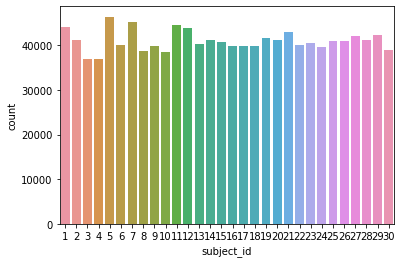

In [10]:
sns.countplot(x='subject_id', data=df)

In [0]:
train_sub = list(range(1,25))
val_sub = list(range(26,31))
test_sub = list(range(26,31))

In [0]:
train_df = df[df['subject_id'].isin(train_sub)]
val_df =  df[df['subject_id'].isin(val_sub)]
test_df = df[df['subject_id'].isin(test_sub)]

## windowing

In [0]:
def create_windowed_dataset(df, features= FEATURES, class_label = LABELS, window_size=1000, stride = 500):
    X = df[features].values
    y = df[class_label].values
    segments = []
    labels = []
    # segments = np.zeros(((len(X)//(window_size//2))-1,window_size,len(features)))
    # labels = np.zeros(((len(y)//(window_size//2))-1))
    current_idx = 0

    seg_start= 0
    seg_end = window_size
    while seg_end <= len(X):
        segments.append(X[seg_start:seg_end])
        labels.append(stats.mode(y[seg_start:seg_end])[0])

        seg_start += stride
        seg_end = seg_start + window_size

    return np.asarray(segments).astype(np.float32), np.asarray(labels)

In [0]:
X_train, y_train = create_windowed_dataset(train_df, window_size=1000, stride = 250)
X_val, y_val = create_windowed_dataset(val_df, window_size=1000, stride = 250)
X_test, y_test = create_windowed_dataset(test_df, window_size=1000, stride = 250)

In [0]:
X_train = X_train.reshape((X_train.shape[0], 40, 25, 6))
X_val = X_val.reshape((X_val.shape[0], 40, 25, 6))
X_test = X_test.reshape((X_test.shape[0], 40, 25, 6))

y_train = tf.keras.utils.to_categorical(y_train-1)
y_val = tf.keras.utils.to_categorical(y_val-1)
y_test = tf.keras.utils.to_categorical(y_test-1)

In [58]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(3931, 40, 25, 6)
(3931, 7)
(818, 40, 25, 6)
(818, 7)
(818, 40, 25, 6)
(818, 7)


## tf data

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [0]:
BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(16, drop_remainder=True)
test_dataset = test_dataset.batch(1)

## Model

In [0]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model, include_dropout=True, dropout_rate=0.2):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.include_dropout = include_dropout
        if include_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, x):
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[:, :tf.shape(x)[1], :]
        if self.include_dropout:
            x = self.dropout(x)
        return x

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model,use_bias=True)
        self.wv = tf.keras.layers.Dense(d_model,use_bias=True)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [0]:
class AggregateAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(AggregateAttention, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.d_model = d_model
        self.query = self.add_weight("learned_query",shape=[1, 1, self.d_model])

    # def build(self, input_shape):
        # initializer=tf.keras.initializers.Orthogonal()
        
    
    def call(self, v, k):
        # batched_query = tf.tile(self.query, [tf.shape(v)[0],1])
        batched_query = tf.tile(self.query, [tf.shape(v)[0],1,1])
        output, attention_weights = self.mha(v, k, batched_query, mask=None)
        output = tf.squeeze(output, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=2)
        return output, attention_weights

    def compute_output_shape(self, input_shape):
        return tf.TensorShape([input_shape[0], self.d_model])

In [0]:
class AggregateAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(AggregateAttentionBlock, self).__init__()
        self.aga = AggregateAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        attn_output, attn_scores = self.aga(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        
        ffn_output = self.ffn(attn_output)  # (batch_size, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out = self.layernorm(ffn_output + attn_output)  # (batch_size, d_model)
        return out, attn_scores

In [0]:
class SelfAttentionBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(SelfAttentionBlock, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2


In [0]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_timesteps, d_model, num_heads, dff, num_sa_blocks=1, add_pe=True, dropout_rate=0.1):
        super(EncoderBlock, self).__init__()
        self.add_pe = add_pe
        self.pe = PositionalEncoding(n_timesteps, d_model)
        self.self_attn_blocks = tf.keras.Sequential(
            [SelfAttentionBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_sa_blocks)]
            )
        self.attn_aggr = AggregateAttentionBlock(d_model, num_heads, dff, dropout_rate)

    def call(self, x):
        if self.add_pe:
            x = self.pe(x)
        x = self.self_attn_blocks(x)
        x, _  = self.attn_aggr(x)
        return x


In [0]:
class HSAEncoder(tf.keras.layers.Layer):
    def __init__(self, n_window, n_timesteps, d_model, num_heads, dff, dropout_rate=0.1):
        super(HSAEncoder, self).__init__()
        self.window_encoder = EncoderBlock(n_timesteps, d_model, num_heads,
                                           dff, num_sa_blocks=2, add_pe=False, 
                                           dropout_rate=dropout_rate)
        self.window_sequence = tf.keras.layers.TimeDistributed(self.window_encoder)
        self.session_encoder = EncoderBlock(n_window, d_model, num_heads,
                                            dff, num_sa_blocks=2, add_pe=True,
                                            dropout_rate=dropout_rate)
    
    def call(self, x):
        x = self.window_sequence(x)
        return self.session_encoder(x)

In [0]:
class MLPClassifier(tf.keras.layers.Layer):
    def __init__(self, num_classes, hidden_layers = [128, 32]):
        super(MLPClassifier, self).__init__()
        self.layers = tf.keras.Sequential(
            [tf.keras.layers.Dense(num_units, activation='relu') for num_units in hidden_layers]
        )
        self.final_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
        self.dropout = tf.keras.layers.Dropout(0.2)

    def call(self, x):
        x = self.layers(x)
        x = self.dropout(x)
        return self.final_layer(x)

In [0]:
class HARModel(tf.keras.Model):
    def __init__(self, num_classes, n_window, n_timesteps, d_model, num_heads, dff, dropout_rate):
        super(HARModel, self).__init__()
        self.data_transform = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(d_model, 1))
        self.encoder = HSAEncoder(n_window, n_timesteps, d_model, num_heads, dff,dropout_rate)
        self.classifier = MLPClassifier(num_classes)

    def call(self, x):
        x = self.data_transform(x)
        x = self.encoder(x)
        return self.classifier(x)

### Training

In [0]:
model = HARModel(num_classes=7, n_window=40, n_timesteps=25,
                 d_model=128, num_heads=8, dff=256, dropout_rate=0.1)

In [0]:
tf.keras.backend.clear_session()
model.compile(tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [86]:
model.build((1, 40, 25, 6))
model.summary()

Model: "har_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri multiple                  896       
_________________________________________________________________
hsa_encoder (HSAEncoder)     multiple                  793856    
_________________________________________________________________
mlp_classifier (MLPClassifie multiple                  20871     
Total params: 815,623
Trainable params: 815,623
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
61/61 [==============================] - 23s 380ms/step - loss: 1.9995 - accuracy: 0.1647 - val_loss: 1.9236 - val_accuracy: 0.1066
Epoch 2/50
61/61 [==============================] - 22s 362ms/step - loss: 1.9225 - accuracy: 0.1726 - val_loss: 1.9460 - val_accuracy: 0.1348
Epoch 3/50
61/61 [==============================] - 22s 363ms/step - loss: 1.9477 - accuracy: 0.1260 - val_loss: 1.9467 - val_accuracy: 0.0564
Epoch 4/50
61/61 [==============================] - 22s 362ms/step - loss: 1.9479 - accuracy: 0.1468 - val_loss: 1.9498 - val_accuracy: 0.0294
Epoch 5/50
61/61 [==============================] - 22s 362ms/step - loss: 1.9530 - accuracy: 0.1493 - val_loss: 1.9450 - val_accuracy: 0.1409
Epoch 6/50
61/61 [==============================] - 22s 363ms/step - loss: 1.9411 - accuracy: 0.1309 - val_loss: 1.9450 - val_accuracy: 0.1471
Epoch 7/50
61/61 [==============================] - 22s 361ms/step - loss: 1.9456 - accuracy: 0.1429 - val_loss: 1.9459 - val_accuracy: 0.1471

KeyboardInterrupt: ignored